In [1]:
import pandas as pd

# Load training, test, and RUL data
train_data = pd.read_csv("/content/train_FD001.txt", delim_whitespace=True, header=None)
test_data = pd.read_csv("/content/test_FD001.txt", delim_whitespace=True, header=None)
rul_data = pd.read_csv("/content/RUL_FD001.txt", delim_whitespace=True, header=None)

# Add column names based on the dataset documentation
column_names = ['unit_number', 'time_in_cycles'] + \
               [f'operational_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]
train_data.columns = column_names
test_data.columns = column_names


<ipython-input-1-1fc6178788c9>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv("/content/train_FD001.txt", delim_whitespace=True, header=None)
<ipython-input-1-1fc6178788c9>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv("/content/test_FD001.txt", delim_whitespace=True, header=None)
<ipython-input-1-1fc6178788c9>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv("/content/RUL_FD001.txt", delim_whitespace=True, header=None)


In [2]:
# View the first few rows of the training data
print(train_data.head())

# Check the distribution of units
print(f"Number of unique engines in training: {train_data['unit_number'].nunique()}")
print(f"Number of unique engines in testing: {test_data['unit_number'].nunique()}")

# Check for missing values
print(train_data.isnull().sum())

   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
0                  100.0                518.67                641.82   
1                  100.0                518.67                642.15   
2                  100.0                518.67                642.35   
3                  100.0                518.67                642.35   
4                  100.0                518.67                642.37   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  ...  \
0         

In [3]:
# Calculate RUL for training data
rul_train = train_data.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_train.columns = ['unit_number', 'max_cycle']

# Merge to calculate RUL as `max_cycle - current_cycle`
train_data = train_data.merge(rul_train, on='unit_number')
train_data['RUL'] = train_data['max_cycle'] - train_data['time_in_cycles']

# Drop `max_cycle` since it's no longer needed
train_data.drop('max_cycle', axis=1, inplace=True)

# Add RUL labels for test data
test_rul = test_data.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_rul.columns = ['unit_number', 'max_cycle']
test_data = test_data.merge(test_rul, on='unit_number')
test_data = test_data.merge(rul_data, left_on='unit_number', right_index=True)
test_data.rename(columns={0: 'RUL'}, inplace=True)

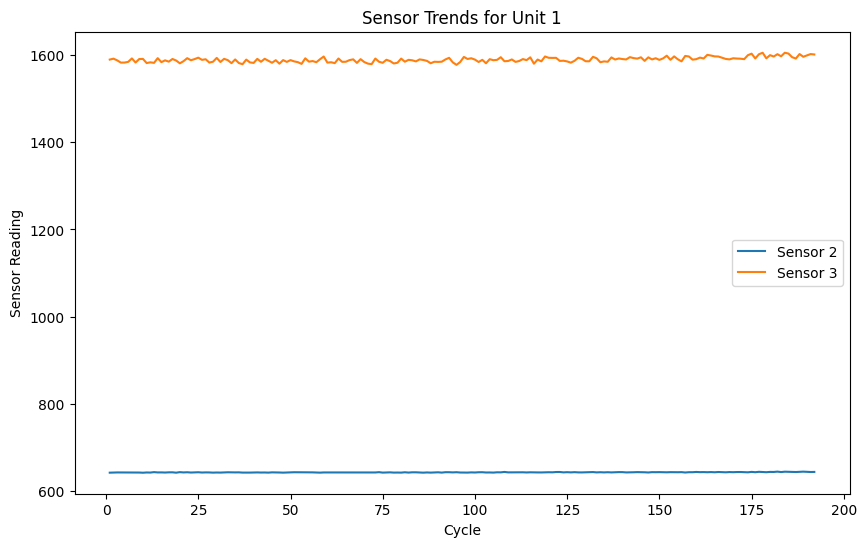

In [4]:
import matplotlib.pyplot as plt

# Example: Plot a sensor trend for a single unit
unit_id = 1
single_unit_data = train_data[train_data['unit_number'] == unit_id]

plt.figure(figsize=(10, 6))
plt.plot(single_unit_data['time_in_cycles'], single_unit_data['sensor_measurement_2'], label='Sensor 2')
plt.plot(single_unit_data['time_in_cycles'], single_unit_data['sensor_measurement_3'], label='Sensor 3')
plt.title(f'Sensor Trends for Unit {unit_id}')
plt.xlabel('Cycle')
plt.ylabel('Sensor Reading')
plt.legend()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Select features and target for training
features = [col for col in train_data.columns if col.startswith('sensor') or col.startswith('operational_setting')]
X = train_data[features]
y = train_data['RUL']

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}")

Training set size: (16504, 24), Validation set size: (4127, 24)


In [6]:
pip install tensorflow scikit-learn pandas matplotlib

In [7]:
import numpy as np

# Function to create sequences for LSTM
def create_sequences(data, sequence_length, features, target):
    X, y = [], []
    for unit in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit]
        unit_features = unit_data[features].values
        unit_target = unit_data[target].values
        for i in range(len(unit_data) - sequence_length + 1):
            X.append(unit_features[i:i+sequence_length])
            y.append(unit_target[i+sequence_length-1])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 30
features = [col for col in train_data.columns if col.startswith('sensor') or col.startswith('operational_setting')]
target = 'RUL'

# Create sequences
X_train_seq, y_train_seq = create_sequences(train_data, sequence_length, features, target)
X_val_seq, y_val_seq = create_sequences(test_data, sequence_length, features, target)

print(f"Training data shape: {X_train_seq.shape}, Validation data shape: {X_val_seq.shape}")

Training data shape: (17731, 30, 24), Validation data shape: (10027, 30, 24)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predicting RUL
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          22,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,233 (137.63 KB)

 Trainable params: 35,233 (137.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 177792208.0000 - mae: 4556.0029 - val_loss: 10074.8594 - val_mae: 87.7987
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1159385.1250 - mae: 668.2921 - val_loss: 25646.4805 - val_mae: 154.5951
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 116882.4688 - mae: 227.8232 - val_loss: 9128.6367 - val_mae: 85.9174
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 70450.9609 - mae: 174.7086 - val_loss: 7108.5264 - val_mae: 73.2250
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 48221.5352 - mae: 143.1459 - val_loss: 7106.6616 - val_mae: 73.2120
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 41485.7695 - mae: 131.6812 - val_loss: 7104.4893 - val_mae: 73.1972
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 39413.7383 - mae: 124.4695 - val_loss: 7101.9238 - val_mae: 73.1797
Epoch 8/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 42105.7734 - mae: 127.19

314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1386.3347 - mae: 32.2212
Validation Loss: 1748.2513427734375, Validation MAE: 37.188480377197266


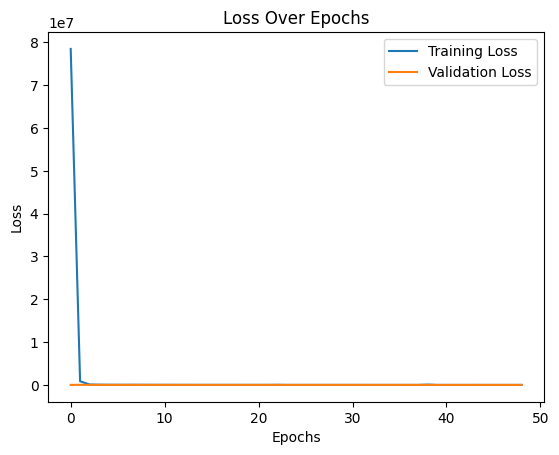

In [10]:
# Evaluate the model
val_loss, val_mae = model.evaluate(X_val_seq, y_val_seq)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


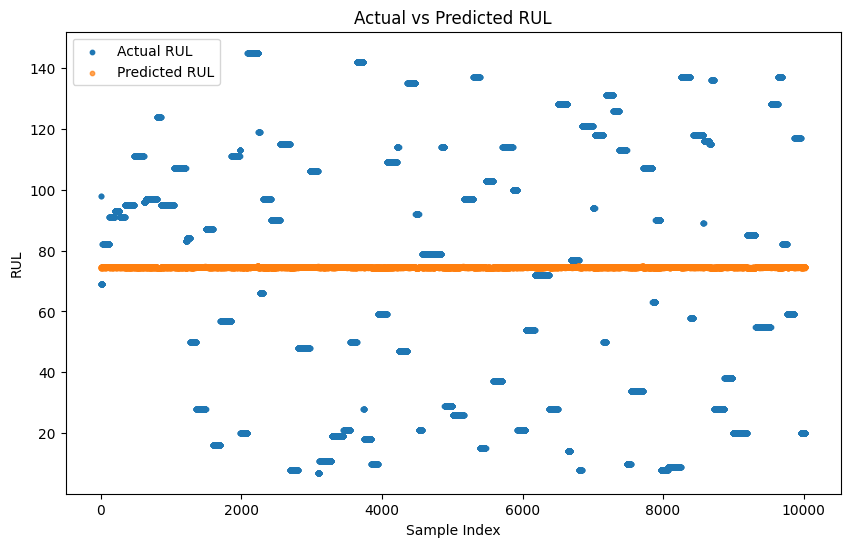

In [11]:
# Predict RUL
y_pred = model.predict(X_val_seq)

# Compare predictions with actual RUL
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_val_seq)), y_val_seq, label='Actual RUL', s=10)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted RUL', s=10, alpha=0.7)
plt.title('Actual vs Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()